In [15]:
import random

random_seed = 10
random.seed(random_seed)

In [16]:
import numpy as np
import pandas as pd
import re

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from google.colab import drive
drive.mount('/content/gdrive')

#shared drive version at everyone can set up
grievances_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
grievances_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


In [17]:
from collections import Counter

corpus = []
for complaint in grievances_df['summary']:
  if not type(complaint) == float:
    corpus.append(complaint)

print(f"corpus: {corpus}\n {len(corpus)}\n set_corpus: {set(corpus)}\n {len(set(corpus))}")

corpus_counts = Counter(corpus)
duplicates = [item for item, count in corpus_counts.items() if count > 1]
print(duplicates)


#code that completely drops duplicates incl. the entire row
#code that only drops duplicates in the corpus using set

corpus: ['That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.', 'The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges that crude oil palm 

In [18]:
!pip install gensim

In [19]:
# More Imports
import os.path
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [20]:
# Code source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Additional stopwords
stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

# remove stopwords, punctuation, and normalize the corpus
stop = set(stopwords.words('english'))
stop.update(stopwords_extra)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

clean_corpus = [clean(doc).split() for doc in corpus]
print(len(clean_corpus))
clean_set_corpus = [clean(doc).split() for doc in set(corpus)]
print(len(clean_set_corpus))
#Compare: Set(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


387
370


In [21]:
# Creating document-term matrix
dictionary = corpora.Dictionary(clean_corpus)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_corpus]


In [22]:
# LDA model
lda = LdaModel(doc_term_matrix, num_topics=7, id2word = dictionary)

# Results
#print(lda.print_topics(num_topics=10, num_words=6))

In [23]:
for i, topic in lda.print_topics(num_topics=7, num_words=6):
    print(f"Topic {i}: {topic}\n")

Topic 0: 0.014*"plantation" + 0.008*"worker" + 0.007*"forest" + 0.007*"illegal" + 0.007*"land" + 0.006*"report"

Topic 1: 0.013*"land" + 0.009*"plantation" + 0.008*"forest" + 0.007*"gar" + 0.006*"deforestation" + 0.005*"complaint"

Topic 2: 0.012*"forest" + 0.010*"pt" + 0.008*"plantation" + 0.007*"land" + 0.005*"right" + 0.005*"area"

Topic 3: 0.015*"earth" + 0.014*"mighty" + 0.014*"rapid" + 0.013*"response" + 0.013*"no" + 0.013*"deforestation"

Topic 4: 0.011*"plantation" + 0.008*"land" + 0.007*"gar" + 0.005*"allegation" + 0.005*"community" + 0.005*"jaya"

Topic 5: 0.013*"land" + 0.011*"area" + 0.007*"plantation" + 0.006*"forest" + 0.006*"deforestation" + 0.005*"1"

Topic 6: 0.015*"land" + 0.009*"forest" + 0.008*"plantation" + 0.007*"worker" + 0.007*"right" + 0.005*"gar"



# LDA Model Creation Functions

In [24]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [25]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [26]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LDA model
        model = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [27]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text = clean_corpus


start,stop,step=2,12,1

Total Number of Documents: 387


In [28]:
# def plot_graph(doc_clean,start, stop, step):
#     dictionary,doc_term_matrix=prepare_corpus(doc_clean)
#     model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
#                                                             stop, start, step)
#     # Show graph
#     x = range(start, stop, step)
#     plt.plot(x, coherence_values)
#     plt.xlabel("Number of Topics")
#     plt.ylabel("Coherence score")
#     plt.legend(("coherence_values"), loc='best')
#     plt.show()

# start,stop,step=2,12,1
# plot_graph(clean_text,start,stop,step)

# Visualizations

In [29]:
model_name = "LDA"

#Input: LDA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None, number_of_topics=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)
        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
            for topic_id, weight in doc
        }

        # Create Dict for Multi-Label Binary Classifcation
        topic_binary = {
            f"Topic_{topic_id}_Indicate": 0
            for topic_id, weight in doc
        }

        shared_perc = 0 # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classifcation

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
            itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row.update(topic_dist) # Add individual topic contributions
        row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [30]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel


# Grab TFIDF matrix from prev functions
dictionary , doc_term_matrix = prepare_corpus(clean_text)

# Format
ldamodel=create_gensim_lda_model(clean_text,number_of_topics=7,words=10)

dominant_topic_df = format_topics_sentences(model=ldamodel, corpus=doc_term_matrix, texts=document_list, number_of_topics=7).reset_index()
dominant_topic_df.head(5)

[(0, '0.010*"forest" + 0.008*"area" + 0.008*"land" + 0.005*"allegation" + 0.004*"ran" + 0.004*"indonesia" + 0.004*"member" + 0.003*"cleared" + 0.003*"pt" + 0.003*"complaint"'), (1, '0.017*"land" + 0.007*"worker" + 0.007*"area" + 0.007*"forest" + 0.005*"allegation" + 0.005*"gar" + 0.004*"pt" + 0.004*"right" + 0.004*"clearance" + 0.003*"complainant"'), (2, '0.018*"land" + 0.010*"plantation" + 0.008*"forest" + 0.006*"subsidiary" + 0.006*"concession" + 0.005*"local" + 0.005*"deforestation" + 0.004*"complaint" + 0.004*"area" + 0.004*"bhd"'), (3, '0.012*"deforestation" + 0.011*"mighty" + 0.011*"earth" + 0.010*"response" + 0.010*"rapid" + 0.010*"forest" + 0.010*"gar" + 0.009*"plantation" + 0.008*"no" + 0.008*"concession"'), (4, '0.010*"plantation" + 0.008*"pt" + 0.008*"gar" + 0.007*"allegation" + 0.007*"forest" + 0.006*"supplier" + 0.006*"national" + 0.006*"deforestation" + 0.005*"member" + 0.005*"park"'), (5, '0.016*"land" + 0.011*"plantation" + 0.008*"community" + 0.008*"forest" + 0.006*"ar

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_6_Perc,Topic_6_Indicate,Topic_0_Perc,...,Topic_1_Perc,Topic_5_Perc,Topic_1_Indicate,Topic_5_Indicate,Topic_2_Perc,Topic_2_Indicate,Topic_3_Perc,Topic_4_Perc,Topic_3_Indicate,Topic_4_Indicate
0,0,6,100.00,"worker, plantation, gar, forest, right, area, ...",That the Respondent allegedly transferred the ...,False,1,100.00,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,98.73,"forest, area, land, allegation, ran, indonesia...",The Complainant alleges that the Respondent ha...,False,1,1.27,0.0,98.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,57.25,"land, worker, area, forest, allegation, gar, p...",1.The Complainant alleges that the Respondent ...,False,1,NaN,NaN,NaN,...,57.25,42.75,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5,100.00,"land, plantation, community, forest, area, rig...",The Respondent's Corporate Social Responsibili...,False,1,NaN,NaN,NaN,...,NaN,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,100.00,"land, plantation, forest, subsidiary, concessi...",The Complainant alleges that the Respondent br...,False,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.0,1.0,NaN,NaN,NaN,NaN


In [31]:
summary = grievances_df['summary'].dropna().tolist()

# LDA Model
number_of_topics=7
words=10
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text = clean_corpus
model= create_gensim_lda_model(clean_text,number_of_topics,words)
model.print_topics()

Total Number of Documents: 387


[(0, '0.010*"gar" + 0.009*"deforestation" + 0.009*"plantation" + 0.008*"response" + 0.007*"rapid" + 0.007*"forest" + 0.007*"earth" + 0.007*"mighty" + 0.007*"no" + 0.005*"right"'), (1, '0.011*"plantation" + 0.010*"forest" + 0.010*"gar" + 0.010*"area" + 0.008*"land" + 0.008*"deforestation" + 0.007*"worker" + 0.007*"concession" + 0.007*"ha" + 0.006*"right"'), (2, '0.011*"land" + 0.007*"2" + 0.006*"member" + 0.006*"worker" + 0.006*"right" + 0.006*"community" + 0.005*"ffb" + 0.005*"national" + 0.005*"plantation" + 0.004*"1"'), (3, '0.013*"land" + 0.007*"forest" + 0.006*"area" + 0.006*"plantation" + 0.006*"1" + 0.005*"allegation" + 0.004*"kalimantan" + 0.004*"sawit" + 0.004*"ha" + 0.004*"gar"'), (4, '0.012*"worker" + 0.010*"land" + 0.006*"member" + 0.005*"area" + 0.005*"deforestation" + 0.005*"earth" + 0.005*"indication" + 0.005*"forest" + 0.005*"ha" + 0.005*"complaint"'), (5, '0.017*"land" + 0.012*"plantation" + 0.011*"forest" + 0.008*"pt" + 0.006*"area" + 0.006*"clearance" + 0.004*"allegat

[(0,
  '0.010*"gar" + 0.009*"deforestation" + 0.009*"plantation" + 0.008*"response" + 0.007*"rapid" + 0.007*"forest" + 0.007*"earth" + 0.007*"mighty" + 0.007*"no" + 0.005*"right"'),
 (1,
  '0.011*"plantation" + 0.010*"forest" + 0.010*"gar" + 0.010*"area" + 0.008*"land" + 0.008*"deforestation" + 0.007*"worker" + 0.007*"concession" + 0.007*"ha" + 0.006*"right"'),
 (2,
  '0.011*"land" + 0.007*"2" + 0.006*"member" + 0.006*"worker" + 0.006*"right" + 0.006*"community" + 0.005*"ffb" + 0.005*"national" + 0.005*"plantation" + 0.004*"1"'),
 (3,
  '0.013*"land" + 0.007*"forest" + 0.006*"area" + 0.006*"plantation" + 0.006*"1" + 0.005*"allegation" + 0.004*"kalimantan" + 0.004*"sawit" + 0.004*"ha" + 0.004*"gar"'),
 (4,
  '0.012*"worker" + 0.010*"land" + 0.006*"member" + 0.005*"area" + 0.005*"deforestation" + 0.005*"earth" + 0.005*"indication" + 0.005*"forest" + 0.005*"ha" + 0.005*"complaint"'),
 (5,
  '0.017*"land" + 0.012*"plantation" + 0.011*"forest" + 0.008*"pt" + 0.006*"area" + 0.006*"clearance"

In [32]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 1]

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_6_Perc,Topic_6_Indicate,Topic_0_Perc,...,Topic_1_Perc,Topic_5_Perc,Topic_1_Indicate,Topic_5_Indicate,Topic_2_Perc,Topic_2_Indicate,Topic_3_Perc,Topic_4_Perc,Topic_3_Indicate,Topic_4_Indicate
2,2,1,57.25,"land, worker, area, forest, allegation, gar, p...",1.The Complainant alleges that the Respondent ...,False,1,NaN,NaN,NaN,...,57.25,42.75,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1,100.00,"land, worker, area, forest, allegation, gar, p...",Allegations raised against the Respondent are ...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,1,100.00,"land, worker, area, forest, allegation, gar, p...",Allegations revolve around land issues where t...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,20,1,100.00,"land, worker, area, forest, allegation, gar, p...",Allegations made against the Respondent are in...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,22,1,91.41,"land, worker, area, forest, allegation, gar, p...",Allegations made against the Respondent are pe...,False,1,1.43,0.0,1.43,...,91.41,1.43,1.0,0.0,1.43,0.0,1.43,1.43,0.0,0.0
24,24,1,100.00,"land, worker, area, forest, allegation, gar, p...",The Complainant alleged that the Respondent vi...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,31,1,100.00,"land, worker, area, forest, allegation, gar, p...",Supply CPO & FFB from unsustainable sources. T...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,34,1,100.00,"land, worker, area, forest, allegation, gar, p...",a) The Respondent did not pay the full land co...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,41,1,100.00,"land, worker, area, forest, allegation, gar, p...",Unilateral pay cut by the Respondent; Poor liv...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,44,1,100.00,"land, worker, area, forest, allegation, gar, p...",The Respondent has acquired land to develop oi...,False,1,NaN,NaN,NaN,...,100.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


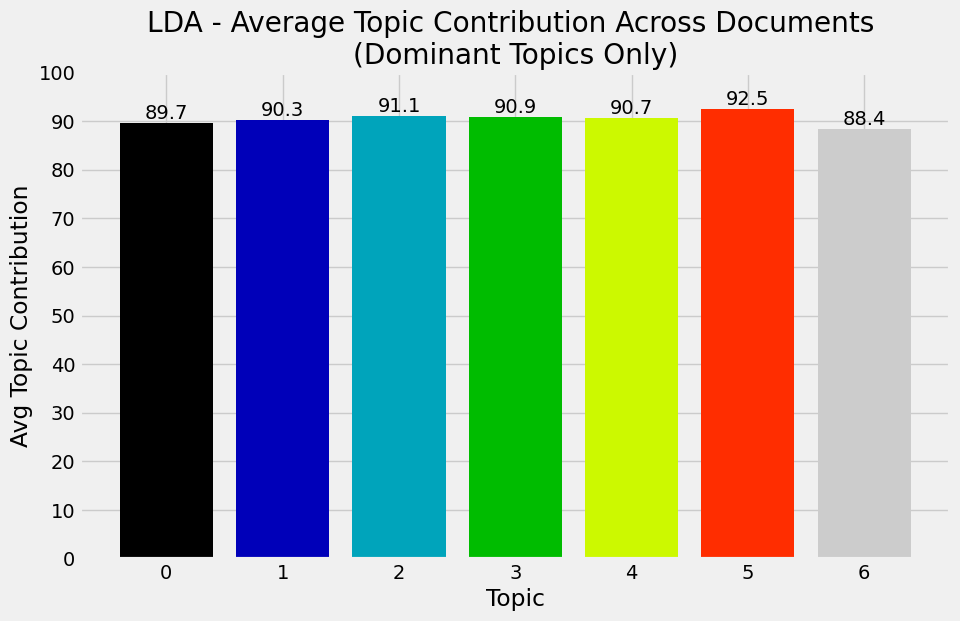

In [33]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

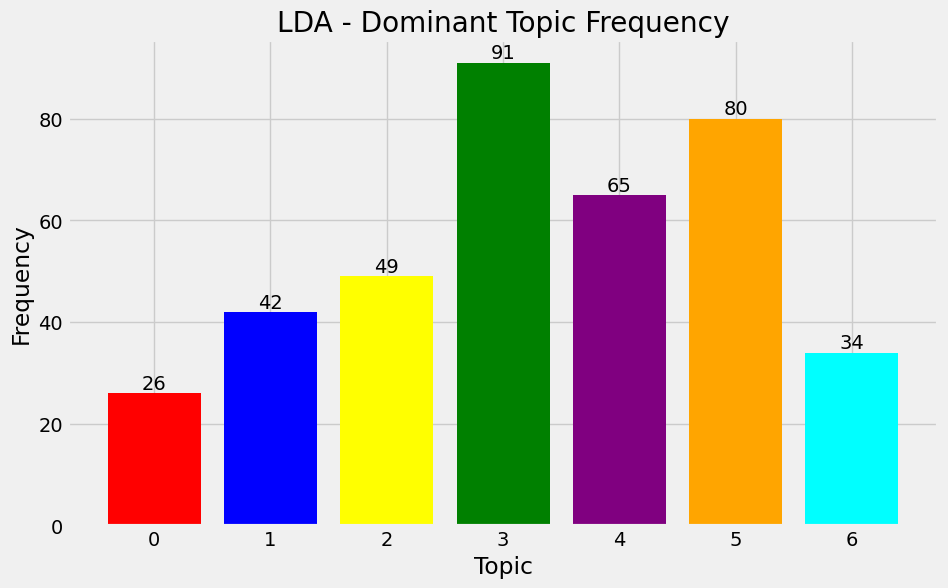

In [34]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

In [35]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['index'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        print(doc_row[col_name])
        print(f"{i},{val}")
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

1    98.73
Name: Topic_0_Perc, dtype: float64
0,98.73
1   NaN
Name: Topic_1_Perc, dtype: float64
1,0.0
1   NaN
Name: Topic_2_Perc, dtype: float64
2,0.0
1   NaN
Name: Topic_3_Perc, dtype: float64
3,0.0
1   NaN
Name: Topic_4_Perc, dtype: float64
4,0.0
1   NaN
Name: Topic_5_Perc, dtype: float64
5,0.0
1    1.27
Name: Topic_6_Perc, dtype: float64
6,1.27


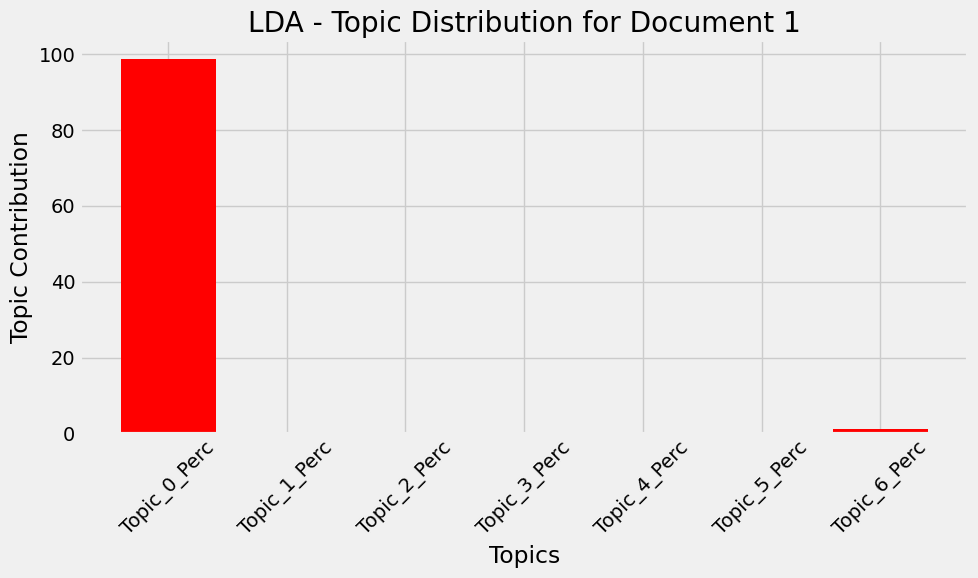

In [42]:
topic_dist_doc(dominant_topic_df, number_of_topics, 1)

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=number_of_topics)

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'Number of Documents')

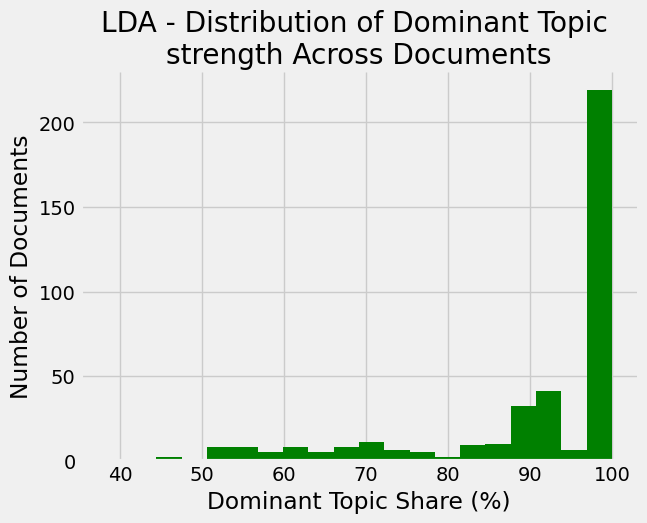

In [38]:
# Displays every doc's dominant topic share as a percentage compared to its other non-dominant topics
# Basically how much weight the dominant topic have throughout each of the documents
dominant_topic_df['Perc_Contribution'].plot(kind='hist', bins=20, title='Perc_Contribution', color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.title(f"{model_name} - Distribution of Dominant Topic \nstrength Across Documents")
plt.xlabel("Dominant Topic Share (%)")
plt.ylabel("Number of Documents")